Over the past year or so, I've been using [JAX](https://jax.readthedocs.io) extensively for my research, and I've also been encouraging other astronomers to give it a try.
In particular, I've been using JAX as the computation engine for probabilistic inference tasks.
There's more to it, but one way that I like to think about JAX is as NumPy with just-in-time compilation and [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).
The just-in-time compilation features of JAX can be used to speed up you NumPy computations by removing some Python overhead and by executing it on your GPU.
Then, automatic differentiation can be used to efficiently compute the derivatives of your code with respect to its input parameters.
These derivatives can substantially improve the performance of numerical inference methods (like maximum likelihood or Markov chain Monte Carlo) and for other tasks such as Fisher information analysis.

This post isn't meant to be a comprehensive introduction to JAX (take a look at [the excellent JAX docs](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) for more of that) or to automatic differentiation ([I've written some words](https://docs.exoplanet.codes/en/latest/tutorials/autodiff/) about that, and [so have many others](https://www.google.com/search?q=automatic+differentiation)), but rather an introduction to the JAX ecosystem for probabilistic inference, with some examples that will be familiar to astronomers.
From my perspective, one benefit of the JAX ecosystem compared to other similar tools available in Python (e.g. [PyMC](https://www.pymc.io), [Stan](https://mc-stan.org), etc.) is that it's generally more modular.
In practice, this means that you can (relatively) easily combine different JAX libraries to develop your preferred workflow.
For example, you can build a probabilistic model using [NumPyro](https://num.pyro.ai) that uses [tinygp](https://tinygp.readthedocs.io) for Gaussian Processes, and then run a Markov chain Monte Carlo (MCMC) analysis using [BlackJAX](https://github.com/blackjax-devs/blackjax).

In this post, however, I'll focus primarily on providing an introduction to [NumPyro](https://num.pyro.ai), which is a probabilistic programming library that provides an interface for defining probabilistic models and running inference algorithms.
At this point, NumPyro is probably the most mature JAX-based probabilistic programming library, and [its documentation page](https://num.pyro.ai) has a lot of examples, but I've found that these docs are not that user-friendly for my collaborators, so I wanted to provide a different perspective.
In the following sections, I'll present two examples:

1. The first example is a fairly simple linear regression problem that introduces some basic NumPyro concepts. In the second half of this example, we will re-implement the model from [my "Mixture Models" post](https://dfm.io/posts/mixture-models/) to account for outliers in the simulated dataset, while also introducing some more advanced elements.

2. The second example is an astronomy-specific problem that is designed to really highlight the power of these methods. In this example, we will measure the distance to the [M67 open cluster](https://en.wikipedia.org/wiki/Messier_67) using a huge hierarchical model for parallaxes measured by [the Gaia Mission](https://sci.esa.int/web/gaia) for stars in the direction of M67. This example includes running an MCMC sampler with thousands of parameters, which would be intractable with the tools commonly used by astronomers, but only takes a few minutes to run using NumPyro.

## Example 1: Linear regression with outliers

In this example, we'll use NumPyro to fit a linear regression model to the data simulated in [my "Mixture models" post](https://dfm.io/posts/mixture-models/).
This simulated dataset has some outliers so, as we'll see below, simple linear regression isn't going to work very well, so we'll extend the model to include a mixture as presented in the aforementioned blog post.
But, to start, let's simulate the dataset:

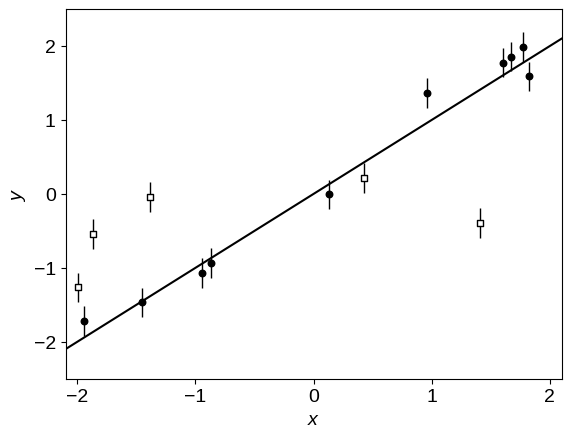

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)


def plot_data():
    plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w", edgecolor="k", zorder=1000)
    plt.scatter(
        x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000, label="data"
    )
    plt.plot(x0, y0, color="k", lw=1.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.1, 2.1)


plot_data()

The line in this figure shows the true linear relation, and the unfilled points are the outliers.
To get started, let's implement a basic linear regression model using NumPyro.
We'll parameterize our model using the angle of the line above horizontal $\theta = \arctan m$ (where $m$ is the slope of the line) and the "perpendicular" intercept $b_\perp = b\,\cos\theta$ (where $b$ has the usual definition of linear intercept).
This choice of parameterization is discussed on [Jake VanderPlas' blog](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), and it's not terribly important for this dataset, but it will let us demonstrate how to re-parameterize models.

In NumPyro, a probabilistic model is defined as a Python function that takes the dataset as input.
In the body of the function, we start by defining the priors on our parameters using the `numpyro.sample` function and probability distributions defined in the `numpyro.distributions` module.
Then we use these parameters to evaluate our model, making sure that we always use `jax.numpy` functions instead of `numpy` functions.
Finally, we define the sampling distribution for the data, again using the `numpyro.sample` function and a distribution.

**Note:** This point is important! You _must_ evaluate model using functions that JAX understands.
In many cases, this isn't a problem since JAX implements most NumPy functions, but this gets more complicated if you need custom (e.g. physically-motivated) functions, but that's a conversation for a different day.

### A simple model with no treatment of outliers

Here's our implementation of a linear model parameterized by $\theta$ and $b_\perp$ without any treatment of outliers:

In [2]:
import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

numpyro.set_host_device_count(2)


def linear_model(x, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0, 1))

    # Transformed parameters (and other things!) can be tracked during sampling using
    # "deterministics" as follows:
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))

    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

Using this model function, we can now use MCMC to sample from the posterior.

In [3]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(linear_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), x, yerr, y=y)

CPU times: user 4.93 s, sys: 47.8 ms, total: 4.98 s
Wall time: 4.94 s


The published version of this post is executed on GitHub Actions with a pretty teeny CPU, but the full runtime for this model is less than 2 seconds on my laptop.
In this case, the runtime is actually probably dominated by JIT compilation and Python overheads, but it's also a pretty simple model with only 2 parameters, so we'd expect it to be fast.

It's always a good idea to check the convergence of your MCMC sampler, and we'll use [ArviZ](https://python.arviz.org) to do that here, looking at the Gelman–Rubin (`r_hat`) statistic, and the effective sample sizes (e.g. `ess_bulk`):

In [4]:
import arviz as az

inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.123,0.052,0.025,0.215,0.001,0.001,4188.0,2913.0,1.0
b_perp,0.098,0.041,0.021,0.172,0.001,0.000,4198.0,2936.0,1.0
m,0.758,0.035,0.695,0.824,0.001,0.000,4019.0,2531.0,1.0
theta,0.648,0.022,0.608,0.689,0.000,0.000,4019.0,2531.0,1.0


Cool - the auto-correlation time of our chains is just over 1, which means that nearly every sample is effectively independent.

Now we can look at [the corner plot](https://corner.readthedocs.io) of the results, and compare to the true values:

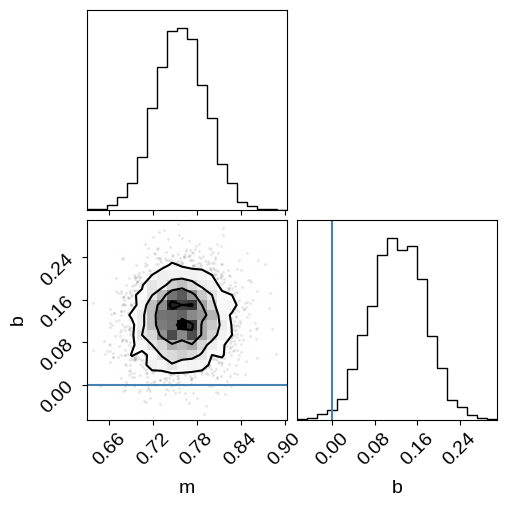

In [5]:
import corner

corner.corner(inf_data, var_names=["m", "b"], truths=true_params);

As in [the mixture models post](https://dfm.io/posts/mixture-models/) that this example is based on, the results are _very wrong_ if we don't take outliers into account.
We'll fix this using a mixture model below, but first let's take a look at one other feature of NumPyro.

You may have noticed in our model definition above, we passed the observed data `y` as a keyword argument instead of as a positional argument.
This is because it lets us reuse the same model for predictive tasks.
For example, we can use the `numpyro.infer.Predictive` interface to do posterior (or prior) predictive checks.
This gives a way of simulating data that we would expect to see, given our posterior (or prior) constraints and sampling distribution, which we can then compare to our observed data.

In this case, let's generate some simulated data from our posterior predictive distribution (note that we don't pass `y` to this function) and over-plot these simulated datasets on the observed data:

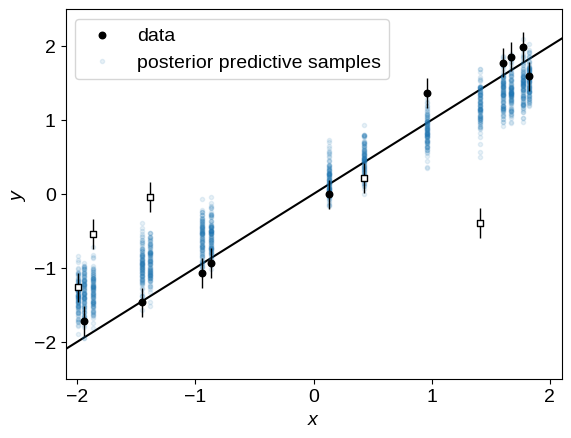

In [6]:
post_pred_samples = infer.Predictive(linear_model, sampler.get_samples())(
    jax.random.PRNGKey(1), x, yerr
)
post_pred_y = post_pred_samples["y"]

plot_data()
label = "posterior predictive samples"
for n in np.random.default_rng(0).integers(len(post_pred_y), size=100):
    plt.plot(x, post_pred_y[n], ".", color="C0", alpha=0.1, label=label)
    label = None
plt.legend();

Unsurprisingly, these simulated datasets are (qualitatively) not a good match to the observed data because of the outliers.
Let's fix that now!

### Taking outliers into account using a mixture model

Now we generalize our model from above to include a mixture distribution to account for the outliers.
We'll use the same mixture model as in the [mixture models post](https://dfm.io/posts/mixture-models/), and you should take a look at that post for a more detailed explanation of the model.
But, in summary, out "foreground" model is the same as the one above, and the "background" model is a Gaussian with a floating mean and standard deviation.
Besides $\theta$ and $b_\perp$, we'll also fit for the mean and standard deviation of the background model, and the mixture weight (called $Q$ in the previous blog post).

NumPyro doesn't actually include a mixture `Distribution` that is flexible enough for everything we need in this post.
There is a [`MixtureSameFamily` distribution](https://num.pyro.ai/en/stable/distributions.html#mixturesamefamily), that would be sufficient for this example, but below we'll need a more general model that allows the different components to have distributions from different families, so let's use the custom `MixtureGeneral` distribution from my [`numpyro-ext` library](https://github.com/dfm/numpyro-ext).
You can install the version used in this post with the following command:

```bash
pip install git+https://github.com/dfm/numpyro-ext.git@8a777010e2b4eb135493cf984b8a9a40e2d99a90#egg=numpyro-ext
```

In [7]:
from numpyro_ext.distributions import MixtureGeneral


def linear_mixture_model(x, yerr, y=None):
    # Our "foreground" model is identical to the one we used previously: a line
    # parameterized by "theta" and "b_perp". Note that we don't wrap the actual
    # sampling distribution in a `numpyro.sample` here because we're going to
    # use it in the mixture distribution below.
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)

    # Our outlier model is a Gaussian where we're fitting for the zero and
    # standard deviation.
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))

    # We use a `Catagorical` distribution to define the outlier probability. We
    # fit for the parameter `Q` which specifies the probability that any
    # individual point is a member of the foreground model. Therefore, the
    # "prior" outlier probability is `1 - Q`.
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    mix = dist.Categorical(probs=jnp.array([Q, 1.0 - Q]))

    # As with the previous model, the use of a `plate` here is optional, but
    # let's do it anyways.
    with numpyro.plate("data", len(x)):
        # The `numpyro.distributions` module doesn't yet implement a mixture
        # distribution that is flexible enough for our use cases, so we'll use
        # one that I implemented in the `numpyro-ext` package. (This is sort of
        # a lie: the `MixtureSameFamily` distribution in NumPyro _would_ work
        # here, but not in our next example, so bear with me!)
        numpyro.sample("obs", MixtureGeneral(mix, [fg_dist, bg_dist]), obs=y)


# Our inference procedure is identical to the one above.
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)

CPU times: user 8.37 s, sys: 27.8 ms, total: 8.4 s
Wall time: 8.32 s


This model is a bit more complicated, but it still runs pretty quickly, with the runtime again dominated by just-in-time compilation (try increasing the number of samples if you don't believe me!).
As before, we can check convergence and make a corner plot:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q,0.666,0.127,0.429,0.889,0.002,0.001,3729.0,2680.0,1.0
b,0.051,0.078,-0.101,0.195,0.001,0.001,3029.0,2191.0,1.0
b_perp,0.037,0.055,-0.069,0.140,0.001,0.001,2990.0,2326.0,1.0
bg_mean,-0.425,0.409,-1.173,0.399,0.008,0.006,2696.0,1858.0,1.0
bg_sigma,0.779,0.539,0.009,1.689,0.010,0.007,2367.0,1634.0,1.0
m,1.007,0.056,0.894,1.106,0.001,0.001,3129.0,2495.0,1.0
theta,0.788,0.028,0.738,0.844,0.000,0.000,3129.0,2495.0,1.0


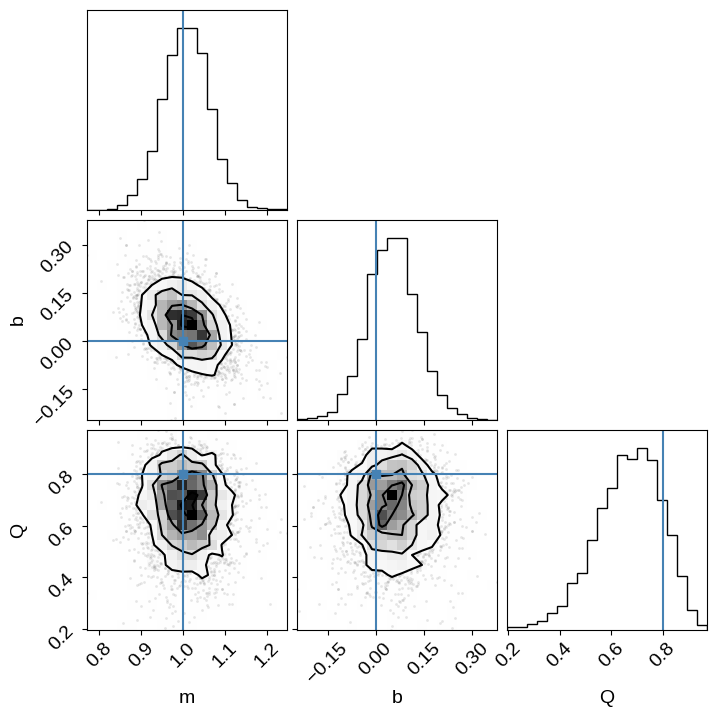

In [8]:
inf_data = az.from_numpyro(sampler)
corner.corner(
    inf_data,
    var_names=["m", "b", "Q"],
    truths={
        "m": true_params[0],
        "b": true_params[1],
        "Q": true_frac,
    },
)
az.summary(inf_data)

This time we recover the true values of the slope, intercept, and outlier probability!

_Added 2022-08-03:_ We can also use this model to identify which points are outliers.
The [mixture models post](https://dfm.io/posts/mixture-models/) describes the math, and you should check out the [mixture membership probabilities](https://dfm.io/posts/mixture-models/#mixture-membership-probabilities) section of that post for more details, but in the meantime, here's an example of how to implement this in NumPyro using out above model:

In [9]:
def linear_mixture_member_prob_model(x, yerr, y=None):
    # Most of the model is identiacal to the one above...
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    mixture = MixtureGeneral(
        dist.Categorical(probs=jnp.array([Q, 1.0 - Q])), [fg_dist, bg_dist]
    )
    with numpyro.plate("data", len(x)):
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Until here, where we can track the membership probability of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "p", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )


# Our inference procedure is identical to the one above.
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_member_prob_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)

CPU times: user 8.46 s, sys: 55.7 ms, total: 8.52 s
Wall time: 8.43 s


As in the mixture models post, we can use the mixture membership probabilities to plot the data points colored by their probability of being an outlier:

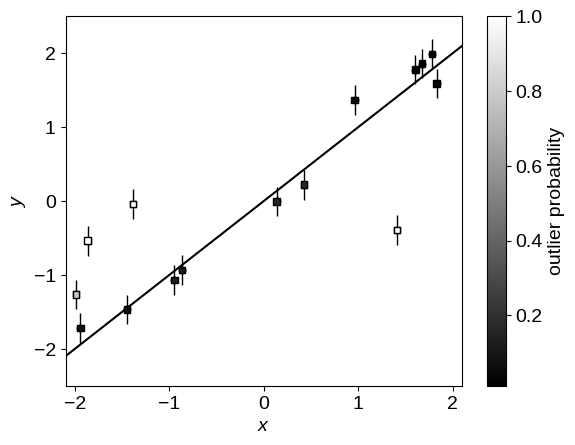

In [10]:
p_fg = jnp.mean(jnp.exp(sampler.get_samples()["p"][..., 0]), axis=0)
plot_data()
plt.scatter(x, y, marker="s", s=22, c=1 - p_fg, edgecolor="k", zorder=1000, cmap="gray")
plt.colorbar(label="outlier probability");

## Example 2: Measuring distances using Gaia parallaxes

In astronomy, we often want to measure distances (to stars, galaxies, etc.), but this is actually quite a difficult measurement to make in general.
One approach for measuring distances to "nearby" stars is to use the [observed parallax](https://en.wikipedia.org/wiki/Stellar_parallax), the apparent shift in position of a star (relative to some reference frame) as our observing angle changes (e.g. as the Earth orbits the Sun).
[The Gaia Mission](https://sci.esa.int/web/gaia) is a European Space Agency mission that is currently measuring the parallaxes of millions of stars in our Galaxy, and we can use these measurements to infer the distances to these stars.
In this tutorial we will look into making such measurements using NumPyro.

Before diving in too deep, I should emphasize that I'm very much not an expert in this field (I just thought it was cool example to try!), so even though I've tried to do/say sensible things here, there may be details that I've missed from the astrophysics perspective.
Furthermore, the final model in this section, while pretty rad, isn't necessarily the best model for measuring the distance to M67 using Gaia, and if you want to use this in production, you may want to include other measurements like proper motion.
If you do see any issues, please let me know by [opening an issue on the GitHub repo for this post](https://github.com/dfm-io/post--intro-to-numpyro/issues), or by emailing me!

For the purposes of this tutorial, I downloaded a sample of measured parallaxes from [the public Gaia Data Release 3 catalog](https://gea.esac.esa.int/archive/) for stars in the direction of the [M67 star cluster](https://en.wikipedia.org/wiki/Messier_67).
Take a look at [here](https://github.com/dfm-io/post--intro-to-numpyro/blob/main/data/README.md) for the specific query that I used.
Let's load these data and take a look at what we see:

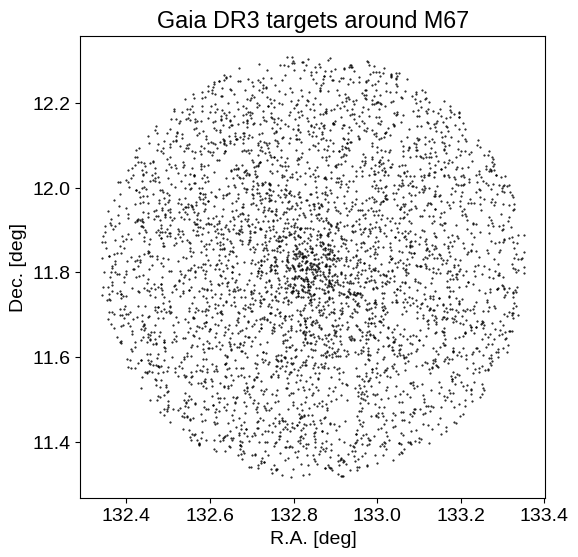

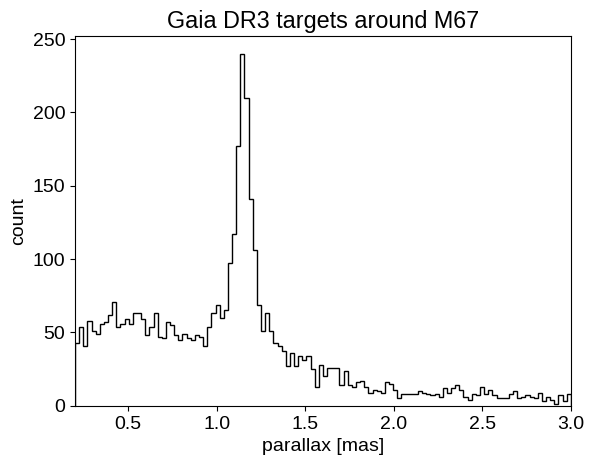

In [11]:
from astropy.io import fits

with fits.open("data/m67.fits.gz") as f:
    data = f[1].data

mask = np.isfinite(data["parallax"])
mask &= np.isfinite(data["parallax_error"])
mask &= data["parallax"] > 0.2
mask &= data["parallax"] < 3.0
data = data[mask]

plt.figure(figsize=(6, 6))
plt.plot(data["ra"], data["dec"], ".k", ms=1)
plt.xlabel("R.A. [deg]")
plt.ylabel("Dec. [deg]")
plt.title("Gaia DR3 targets around M67")

plt.figure()
plt.hist(data["parallax"], 120, histtype="step", color="k")
plt.xlabel("parallax [mas]")
plt.ylabel("count")
plt.title("Gaia DR3 targets around M67")
plt.xlim(0.2, 3.0);

We can see the M67 over-density of stars in both sky position, and parallax.
By the end of this example, we will use (just) these parallax measurements to constrain the distance to M67.

But to start with, we need to estimate the expected parallax zero point offsets for all of our targets.
To do this, we can use the [gaiadr3-zeropoint](https://pypi.org/project/gaiadr3-zeropoint) Python package:

In [12]:
import warnings
from zero_point import zpt

zpt.load_tables()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    plx_zp = zpt.get_zpt(
        data["phot_g_mean_mag"],
        data["nu_eff_used_in_astrometry"],
        data["pseudocolour"],
        data["ecl_lat"],
        data["astrometric_params_solved"],
    )
plx_zp[~np.isfinite(plx_zp)] = 0.0

With these in hand, we can start with a warmup.

### Warmup: Measuring the distance to a star

Let's start with a simple example of measuring the distance to a single star from this sample.
This may seem simple ("the distance is just the inverse of parallax, right?"), but as has been extensively discussed in the literature (see, for example, this seminal paper: [Bailer-Jones 2015](https://arxiv.org/abs/1507.02105)), things aren't quite so simple.
A common practice in this field is to use a probabilistic model for the parallax measurements with a sensible prior on the distance to more robustly propagate the measurement uncertainty to the distance constraint.
[Bailer-Jones (2015)](https://arxiv.org/abs/1507.02105) and other subsequent publications advocate for the following prior on the distance $r$:
$$
p(r) = \frac{r^2}{2\,L^3}\,e^{-r/L}
$$
where $L$ is a length scale parameter that will depend on the sky position of the target, and possibly other parameters.

To use this prior in NumPyro, we need to figure out how to specify it using the existing `Distribution` objects, or by implementing a custom distribution.
When I first started writing this post I couldn't figure out how to sample from this prior, but then I realized that it's just a [chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) with 6 degrees of freedom.
More explicitly, if some variable $u$ is distributed as a chi-squared distribution with 6 degrees of freedom, then $r = u \times L / 2$ is distributed following the distribution above.
To implement this in NumPyro, we can use the `Chi2` distribution, and then scale it by the appropriate factor.
Let's check to make sure that that gives the correct results:

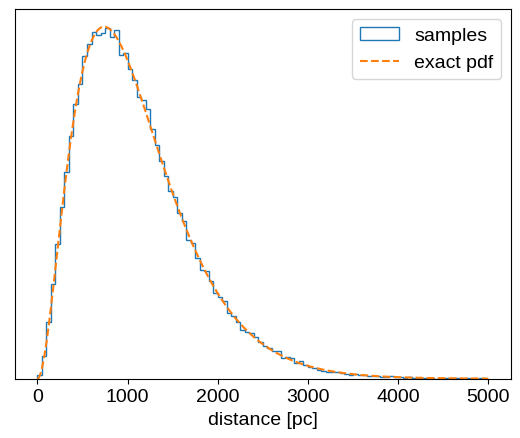

In [13]:
L = 370.0  # A totally arbitrary choice!
prior = dist.TransformedDistribution(
    dist.Chi2(6),
    dist.transforms.AffineTransform(0.0, 0.5 * L),
)
r = prior.sample(jax.random.PRNGKey(0), sample_shape=(100_000,))

x = np.linspace(0, 5000, 500)
plt.hist(r, 100, range=(0, 5000), density=True, histtype="step", label="samples")
plt.plot(x, 0.5 * x**2 * np.exp(-x / L) / L**3, "--", label="exact pdf")
plt.xlabel("distance [pc]")
plt.yticks([])
plt.legend();

That looks good!

We have also just introduced two new NumPyro features: the `TransformedDistribution` distribution and the `AffineTransform`.
The former allows us to specify a distribution that is a transformation of another distribution, and the latter provides an interface for linearly transforming a distribution.
In simple cases, these features can be overkill (and we'll start with an example where we don't use them), but for more complicated problems, they can really come in handy for building expressive distributions like the one we'll get to eventually.

Now that we've got our prior sorted out, let's implement a simple model to estimate the parallax of one target from our sample.
Here's our implementation (note that we're not directly using the `AffineTransform` here, but we could have):

In [14]:
def gaia_single_model(plx_err, plx=None, plx_zp=0.0, L=370.0):
    normed = numpyro.sample("normed", dist.Chi2(6))
    distance = numpyro.deterministic("r", 0.5 * L * normed)
    numpyro.sample("plx", dist.Normal(1000.0 / distance + plx_zp, plx_err), obs=plx)

In this implementation we have included input parameters for the parallax zero point offset and the prior length scale.
For the purposes of our demonstration, we'll set these parameters to arbitrary values, but they should be treated with more care if you wanted to use such a model in practice.

Before we run inference, let's look at how we can use this function to sample from our prior.
As we did with the posterior predictive checks above, we can use the `Predictive` interface to sample from the prior:

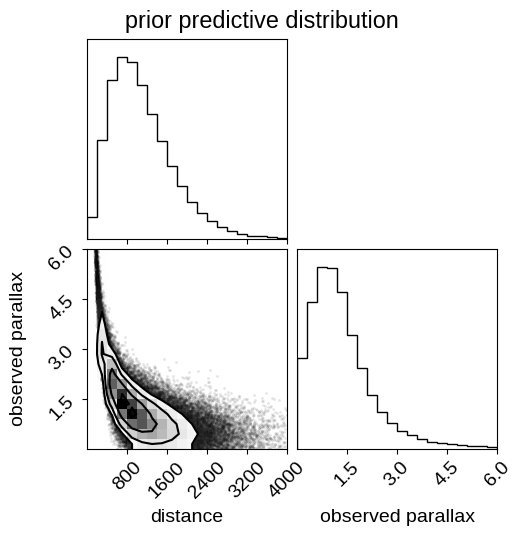

In [15]:
prior_samples = infer.Predictive(gaia_single_model, num_samples=100_000)(
    jax.random.PRNGKey(4), 0.5
)
prior_samples = az.from_dict(prior_samples, num_chains=1)
fig = corner.corner(
    prior_samples,
    var_names=["r", "plx"],
    labels=["distance", "observed parallax"],
    range=[(0, 4000), (0, 6)],
)
fig.suptitle("prior predictive distribution");

Note that in this figure the relationship between distance and parallax is not one-to-one because this distribution takes the sampling distribution for the parallax into account.
Therefore, this shows the prior distribution over _mean observed parallax_ given some parallax uncertainty, which we provided above.
These prior predictive samples can be useful for (at least qualitatively) checking that your priors are sensible when projected into the space of the data.

Now that our model is set up, we can run inference for one of the (relatively low signal-to-noise) targets in the sample.
Note that I wouldn't generally advocate for using MCMC to do posterior inference in a one-dimensional model—it's pretty much always better to use quadrature or something in 1D—but here we go!

CPU times: user 3.06 s, sys: 0 ns, total: 3.06 s
Wall time: 3.03 s


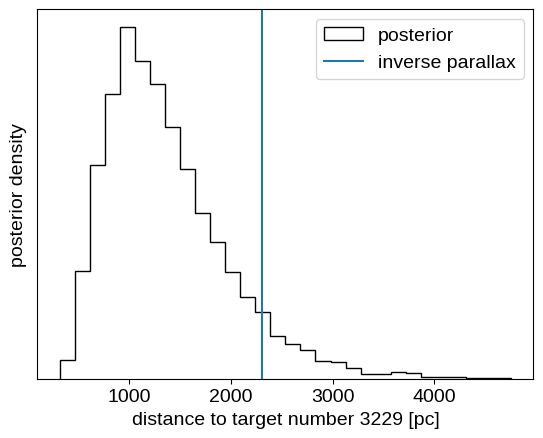

In [16]:
snr = data["parallax"] / data["parallax_error"]
single_ind = np.argsort(snr)[115]
plx = data[single_ind]["parallax"]
plx_err = data[single_ind]["parallax_error"]
sampler = infer.MCMC(
    infer.NUTS(gaia_single_model),
    num_warmup=2000,
    num_samples=4000,
    num_chains=2,
)
%time sampler.run(jax.random.PRNGKey(5), plx_err, plx=plx, plx_zp=plx_zp[single_ind])

samples_single = sampler.get_samples()
plt.hist(samples_single["r"], 30, histtype="step", color="k", label="posterior")
plt.axvline(1000.0 / plx, label="inverse parallax")
plt.xlabel(f"distance to target number {single_ind} [pc]")
plt.ylabel("posterior density")
plt.legend(loc=1)
plt.yticks([]);

This is a case where the inferred distance is somewhat inconsistent with the value computed by inverting the parallax as a distance estimator.

### Inferring the distance to M67 using a hierarchical model for parallax

Now that we've seen how the single target model works, let's build a more sophisticated model that combines everything that we've learned so far.
In this section, we'll build a joint (hierarchical) model for all 4300 targets in the sample to simultaneously fit for:

1. the individual distances to each target $r_n$,
2. the fraction of targets that are cluster members $Q$ (based only on the parallax, mind you!),
3. the background length scale of the background (and foreground) distribution $L$, and
4. the distance $D$ and width $\sigma$ (in log distance) of M67.

We're modeling the cluster itself as a Gaussian in log distance, and the background using the Bailer-Jones distribution discussed above with the length scale as a free parameter.
This model has 4304 parameters (4 population parameters and then one distance for each target), so this would be pretty hard to sample with most MCMC methods, but as we'll see below, NumPyro has no problem.

Here's our implementation of the model:

In [17]:
def gaia_cluster_model(plx_err, plx=None, plx_zp=0.0):
    # We start by defining our priors on the population parameters described
    # above. For most, of these parameters, we use wide Gaussian priors in log
    # since our main information about these parameters is that they must be
    # positive. We could have also used uniform priors (perhaps still in the
    # log), but you'll often get better performance using a prior with some
    # curvature.
    log_L = numpyro.sample("log_L", dist.Normal(np.log(370.0), 2.0))
    log_D = numpyro.sample("log_D", dist.Normal(np.log(920.0), 2.0))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0.0, 2.0))
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))

    # We'll track some reparameterized values for plotting later.
    L = numpyro.deterministic("L", jnp.exp(log_L))
    numpyro.deterministic("D", jnp.exp(log_D))

    # We're also going to track the approximate size of the cluster in linear
    # space, also for plotting purposes. This is only an approximation since
    # we're modeling the cluster in log distance, but it should be close enough
    # for making some plots.
    numpyro.deterministic("approx_size", jnp.exp(log_sigma + log_D))

    with numpyro.plate("stars", len(plx_err)):

        # The background distance distribution is the same as the one we used
        # above, but this time we fit for the length scale L. Another difference
        # is that we're "transforming" the distribution using an affine
        # transformation, instead of sampling in the "normalized distance" and
        # then multiplying by 0.5*L like we did above. These two approaches are
        # equivalent, but we need to specify a single distribution here for use
        # in the MixtureGeneral distribution below.
        dist_bg = dist.TransformedDistribution(
            dist.Chi2(6),
            dist.transforms.AffineTransform(
                0.0, 0.5 * L, domain=dist.constraints.positive
            ),
        )

        # The foreground distribution is a Gaussian in log distance. Like with
        # the background distribution, we use a transformation to convert from a
        # Gaussian in log distance to a distribution in distance.
        dist_fg = dist.TransformedDistribution(
            dist.Normal(log_D, jnp.exp(log_sigma)),
            dist.transforms.ExpTransform(),
        )

        # Now we "mix" the foreground and background distributions using the
        # "cluster membership fraction" parameter to specify the mixing weights.
        mixture = MixtureGeneral(
            dist.Categorical(probs=jnp.stack((Q, 1 - Q), axis=-1)),
            [dist_fg, dist_bg],
        )
        r = numpyro.sample("r", mixture)

        # As before, we'll track the probability that each star is a member of
        # the cluster. Note that our mixture is a distribution in *distance* so
        # we're evaluating the class probabilities using `r` instead of `plx`,
        # which is what we would have done in the earlier example. This is the
        # right way to do it since, at each step in the MCMC, `r` is our current
        # belief about the "true" distance to each star, which sets our belief
        # about its membership probability.
        log_probs = mixture.component_log_probs(r)
        numpyro.deterministic(
            "p", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

        # Finally, we convert the distance to parallax and add the zero-point offset.
        plx_true = numpyro.deterministic("plx_true", 1000.0 / r + plx_zp)
        numpyro.sample("plx_obs", dist.Normal(plx_true, plx_err), obs=plx)

As above, let's see what our prior predictive distribution looks like:

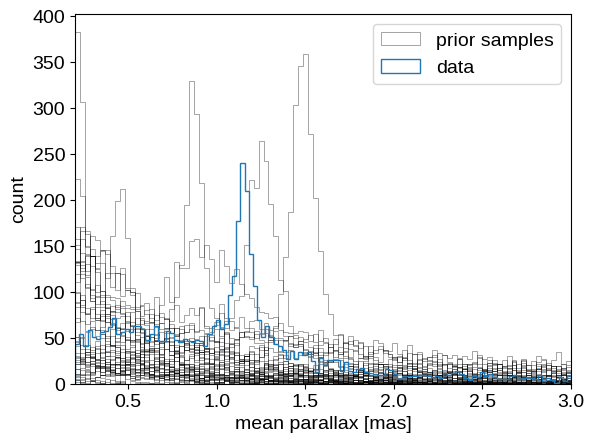

In [18]:
# The array parallax errors is required by the model even when prior sampling.
# In our model, the parallax errors aren't _data_, they are part of the model.
plx = np.ascontiguousarray(data["parallax"], dtype=np.float32)
plx_err = np.ascontiguousarray(data["parallax_error"], dtype=np.float32)

# Generate samples from the prior...
prior_pred = infer.Predictive(gaia_cluster_model, num_samples=50)(
    jax.random.PRNGKey(11), plx_err, plx_zp=plx_zp
)

# ...and plot them:
label = "prior samples"
for n in range(len(prior_pred["plx_obs"])):
    plt.hist(
        prior_pred["plx_obs"][n],
        100,
        range=(0.2, 3.0),
        histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
    )
    label = None

plt.hist(data["parallax"], 120, histtype="step", color="C0", label="data")
plt.legend()
plt.xlabel("mean parallax [mas]")
plt.ylabel("count")
plt.xlim(0.2, 3);

Comparing the observed distribution of parallax measurements to the prior samples, this doesn't look like an outrageously implausible realization.
So let's just bite the bullet and run the MCMC:

In [19]:
sampler = infer.MCMC(
    infer.NUTS(gaia_cluster_model),
    num_warmup=2000,
    num_samples=4000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(7), plx_err, plx=plx, plx_zp=plx_zp)

CPU times: user 21min 50s, sys: 1.48 s, total: 21min 52s
Wall time: 11min 3s


Again, the published version of this post was executed on GitHub Actions, so you'll probably find that this runs a little faster on your own machine (this takes about 5 minutes on my laptop).
Even so, this model definitely takes a little longer to run than the earlier examples, but remember that we're fitting thousands of parameters here, so I'm willing to take this hit as long as the results are sensible.
Let's take a look at the results:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,469.582,7.079,456.132,482.660,0.126,0.089,3145.0,6311.0,1.00
D,836.914,0.988,835.085,838.780,0.017,0.012,3370.0,6108.0,1.00
approx_size,14.580,1.245,12.247,16.947,0.086,0.061,209.0,559.0,1.01
Q,0.424,0.011,0.404,0.446,0.001,0.000,369.0,882.0,1.00


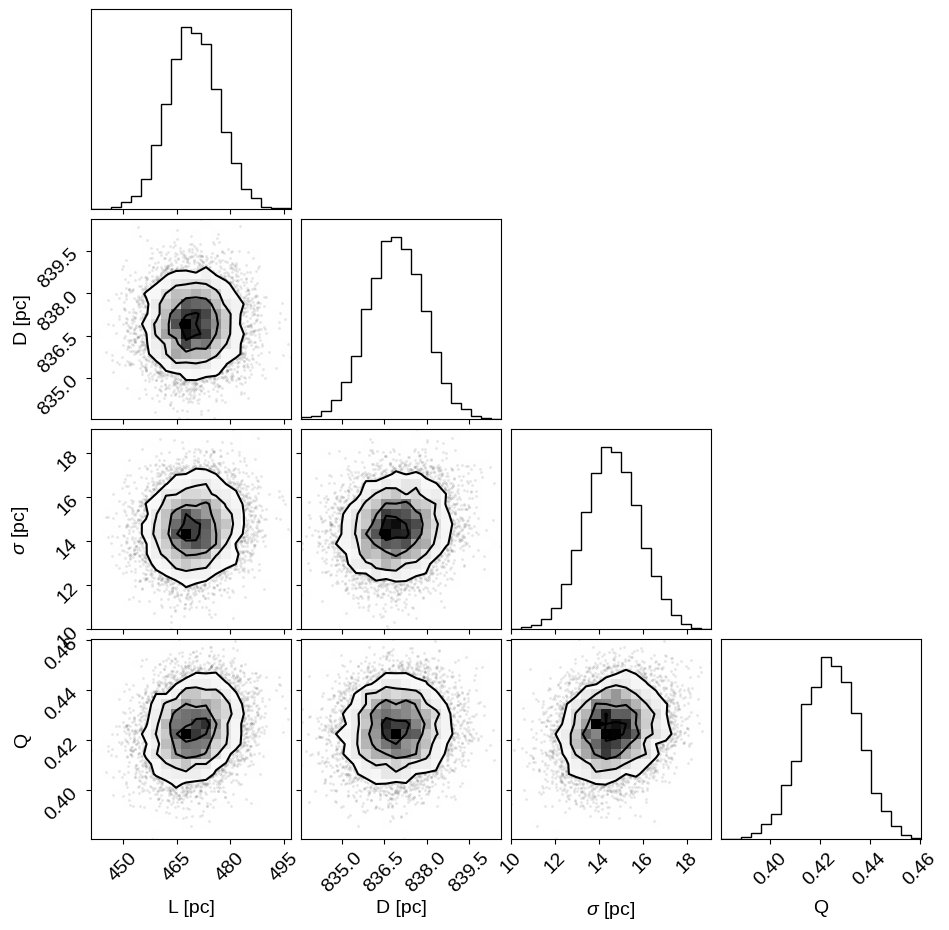

In [20]:
samples = sampler.get_samples()
inf_data = az.from_numpyro(sampler)
corner.corner(
    inf_data,
    var_names=["L", "D", "approx_size", "Q"],
    labels=["L [pc]", "D [pc]", "$\sigma$ [pc]", "Q"],
)
az.summary(inf_data, var_names=["L", "D", "approx_size", "Q"])

The sampling efficiency isn't quite as good as it has been for the simpler models, but the $\hat{R}$ statistics are good and we've still generated hundreds of effective samples, with thousands of effective samples for the cluster distance.
Given these results, we estimate the distance to M67 to be:

In [21]:
print(f"D = {np.mean(samples['D']):.1f} ± {np.std(samples['D']):.1f} pc")

D = 836.9 ± 1.0 pc


with an intrinsic width of:

In [22]:
print(
    f"sigma = {np.mean(samples['approx_size']):.1f} ± {np.std(samples['approx_size']):.1f} pc"
)

sigma = 14.6 ± 1.2 pc


Please note that specifics of these results should be taken with a grain of salt, since there are several subtleties that have not been carefully handled.
This result is quite sensitive to the parallax zero point offsets, and any uncertainty in that should be taken into account.
Similarly, I didn't do anything to remove binary stars from the sample, or to provide more information (e.g. proper motions) to help constrain the cluster membership probability.

That being said, let's see what we can say about the cluster membership probability for each target.
Since our measurement of the cluster membership is based _only_ on our inferred distance, our sample of cluster members is not very clean, but if we plot the color magnitude diagram for our sample colored by the cluster membership probability, things look pretty good:

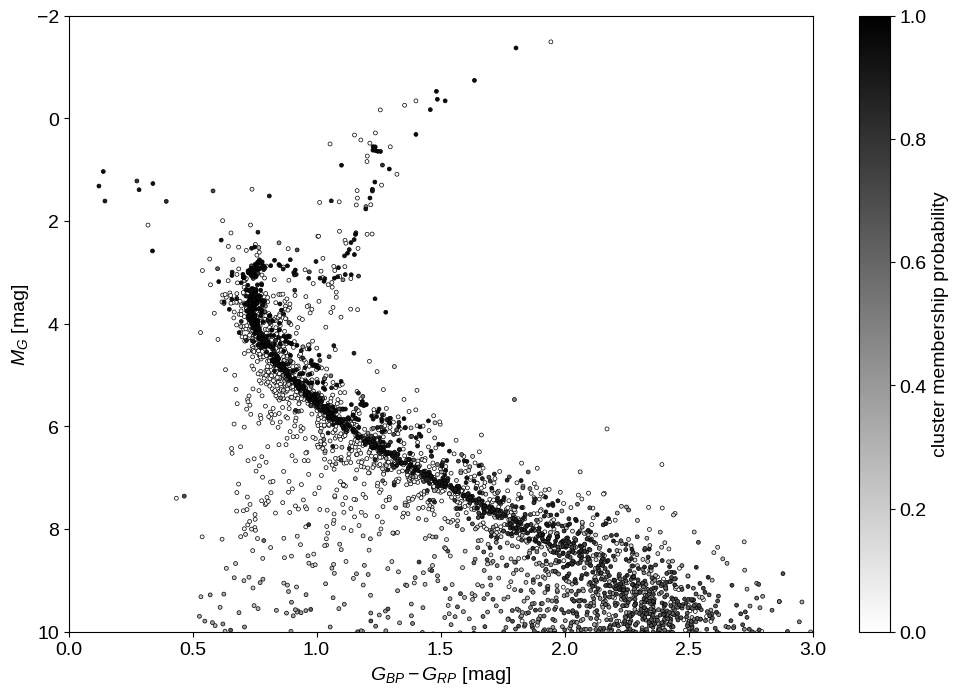

In [23]:
p_cluster = jnp.mean(jnp.exp(samples["p"][..., 0]), axis=0)
idx = jnp.argsort(p_cluster)
plt.figure(figsize=(12, 8))
dm = np.median(5 * np.log10(samples["r"]) - 5, axis=0)
plt.scatter(
    data["bp_rp"][idx],
    data["phot_g_mean_mag"][idx] - dm[idx],
    s=8,
    c=p_cluster[idx],
    cmap="gray_r",
    edgecolors="k",
    linewidths=0.5,
    vmin=0,
    vmax=1,
)
plt.ylim(10, -2)
plt.xlim(0, 3)
plt.colorbar(label="cluster membership probability")
plt.xlabel("$G_{BP} - G_{RP}$ [mag]")
plt.ylabel("$M_G$ [mag]");

Finally, let's wrap up by looking at the posterior predictive distribution for the parallax measurements to at least qualitatively check our modeling choices.
As before, we generate realizations of the catalog conditioned on the posterior samples and compare that to the observed distribution of parallax measurements:

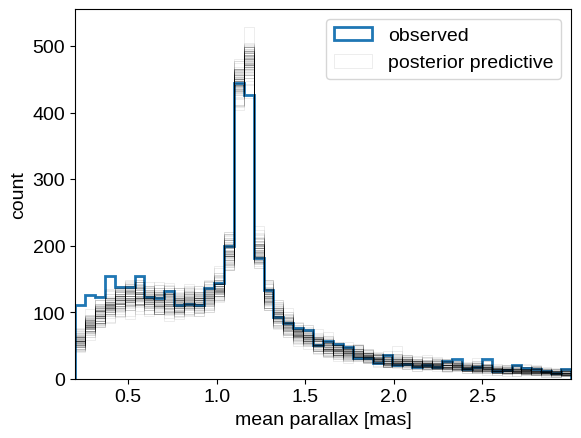

In [24]:
pred = infer.Predictive(gaia_cluster_model, samples)(
    jax.random.PRNGKey(10), plx_err, plx_zp=plx_zp
)

_, bins, _ = plt.hist(plx, 50, histtype="step", lw=2, label="observed")
label = "posterior predictive"
for n in np.random.default_rng(0).integers(len(pred["plx_obs"]), size=100):
    plt.hist(
        pred["plx_obs"][n],
        bins,
        histtype="step",
        color="k",
        alpha=0.1,
        lw=0.5,
        label=label,
    )
    label = None
plt.legend()
plt.xlabel("mean parallax [mas]")
plt.ylabel("count")
plt.xlim(bins[0], bins[-1]);

This looks overall pretty good.
We see some systematic differences at small values of parallax that may have been introduced by our initial cut on the parallax measurements.
We may also be somewhat overestimating the number of cluster members, possibly since our "Gaussian in log distance" model for the cluster is not quite right.
All that being said, these results don't seem too bad, and I definitely think we've seen an example where NumPyro's use really shows!

## Summary

In this post, we've gone through a couple of examples of how one might go about using NumPyro to do Bayesian inference, with a specific focus on applications in astrophysics.
I hope that this is useful for anyone who is interested in learning about how to use these types of tools, and perhaps there are even some interesting tidbits for those who are already experts.
If you have any comments or questions, please [open an issue on the GitHub repository for this post](https://github.com/dfm-io/post--intro-to-numpyro), [Tweet at me](https://twitter.com/exoplaneteer), or (if you must :D) send an email.

_Edit 2022-08-03:_ Incorporated some comments from Morgan Fouesneau.